In [2]:
# Author: Antoine Grenier (TAU)

%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import scipy as sp
import gps_time
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import warnings

pd.set_option('float_format', '{:f}'.format)
 
sys.path.append(os.path.abspath(os.path.join('..')))
from logparser import LogReader

In [4]:
# Load log files
folder = "/mnt/c/Users/vmangr/Documents/Datasets/AndroidDevices/dataset_GEOLOC_20240319/dataset/S1/A1"
device = 'GPW'
file = [file for file in os.listdir(f"{folder}/{device}") if "log_mimir" in file][0]

tags = ['Fix', 'GYR_UNCAL', 'Raw']

log = LogReader(manufacturer="", device="", acronym=device, specifiedTags=tags, filepath=f"{folder}/{device}/{file}", mode='old')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/vmangr/Documents/Datasets/AndroidDevices/dataset_GEOLOC_20240319/dataset/S1/A1/GPW'

In [ ]:
df_time = log.fix.loc[log.fix["provider"] == 'GPS']
df_time = df_time.set_index('unixTime')
df_time = df_time[['elapsedTime', 'elapsedTimeUncertainty']]

df_motion = log.motion
df_motion['timestamp'] = df_motion['timestamp']*1e3
df_motion = df_motion.set_index('timestamp')
df_motion = df_motion[['elapsedRealtime']]

df_motion = df_motion.merge(df_time, how='outer', left_index=True, right_index=True)
df_motion = df_motion.reset_index()
df_motion_intep = df_motion.interpolate()
merged_df_intep['diff'] = (merged_df_intep['elapsedRealtime'] - merged_df_intep['elapsedTime']) / 1e9
merged_df_intep.dropna()
# i = 8850
# merged_df.iloc[i:i+25]

,index,elapsedRealtime,elapsedTime,elapsedTimeUncertainty,diff
1643,1710324849732.000000,87167666539776.000000,87168641208577.000000,200000000.000000,-0.974669
1644,1710324849747.000000,87167668979276.000000,87168646164943.343750,200000000.000000,-0.977186
1645,1710324849748.000000,87167673854401.000000,87168651121309.671875,200000000.000000,-0.977267
1646,1710324849748.000000,87167678729526.000000,87168656077676.015625,200000000.000000,-0.977348
1647,1710324849748.000000,87167683604651.000000,87168661034042.359375,200000000.000000,-0.977429
...,...,...,...,...,...
133610,1710325490617.000000,87808544230990.000000,87807959402009.000000,200000000.000000,0.584829
133611,1710325490617.000000,87808549106240.000000,87807959402009.000000,200000000.000000,0.589704
133612,1710325490617.000000,87808553981490.000000,87807959402009.000000,200000000.000000,0.594579
133613,1710325490618.000000,87808558856740.000000,87807959402009.000000,200000000.000000,0.599455


In [ ]:
df_time = log.fix.loc[log.fix["provider"] == 'GPS']
df_time = df_time.set_index('elapsedTime')
df_time = df_time[['unixTime', 'elapsedTimeUncertainty']]

df_motion = log.motion
df_motion['timestamp'] = df_motion['timestamp']*1e3
df_motion = df_motion.set_index('elapsedRealtime')
df_motion = df_motion[['timestamp']]

merged_df = df_motion.merge(df_time, how='outer', left_index=True, right_index=True)
merged_df
merged_df = merged_df.reset_index()
merged_df_intep = merged_df.interpolate()
merged_df_intep['diff'] = (merged_df_intep['unixTime'] - merged_df_intep['timestamp']) / 1e3
merged_df_intep.dropna()

,index,timestamp,unixTime,elapsedTimeUncertainty,diff
1843,87168641208577.000000,1710324850703500.000000,1710324849732.000000,200000000.000000,-1708614525853.768066
1844,87168644595276.000000,1710324850722000.000000,1710324849736.713623,200000000.000000,-1708614525872.263184
1845,87168649474276.000000,1710324850722000.000000,1710324849741.427246,200000000.000000,-1708614525872.258545
1846,87168654353276.000000,1710324850722000.000000,1710324849746.140869,200000000.000000,-1708614525872.253662
1847,87168659232276.000000,1710324850722000.000000,1710324849750.854492,200000000.000000,-1708614525872.249268
...,...,...,...,...,...
133653,87808544230990.000000,1710325490617000.000000,1710325488999.000000,200000000.000000,-1708615165128.000977
133654,87808549106240.000000,1710325490617000.000000,1710325488999.000000,200000000.000000,-1708615165128.000977
133655,87808553981490.000000,1710325490617000.000000,1710325488999.000000,200000000.000000,-1708615165128.000977
133656,87808558856740.000000,1710325490618000.000000,1710325488999.000000,200000000.000000,-1708615165129.000977


## Interpolate and re-align measurements

In [20]:
def AlignAndIntepolate(_df_fix, _df_motion, columns, output_file, survey_name):
    """
    Align IMU measurement to GPS TOW based on fix measurements and interpolate to regular steps.
    """

    # Select only GPS provider positions, as they are guaranted to be align on GPS time
    # as defined by Android developer documentation
    df_time = _df_fix.loc[_df_fix["provider"] == 'GPS']
    if df_time.empty:
        warnings.warn(f"No position provided by GPS_PROVIDER found for {survey_name}. Aborting.", stacklevel=2)
        return -1

    # Prepare time correction
    df_time = df_time[['unixTime', 'elapsedTime', 'elapsedTimeUncertainty']]
    df_time = df_time.rename(columns={'unixTime': 'timestamp_gps'})

    # Drop columns that have low time uncertainty (if possible)
    if df_time.drop(df_time[df_time['elapsedTimeUncertainty'] > 1e6].index).empty:
        warnings.warn(f"No position with valid time uncertainty found for {survey_name}.", stacklevel=2)
    else:
        df_time = df_time.drop(df_time[df_time['elapsedTimeUncertainty'] > 1e6].index)
    df_time = df_time.drop(['elapsedTimeUncertainty'], axis=1)
    df_time = df_time.set_index('elapsedTime')

    # Prepare motion sensors
    df_motion = _df_motion[['elapsedRealtime', 'timestamp'] + columns]
    df_motion = df_motion.rename(columns={'elapsedRealtime': 'elapsedTime'})
    df_motion = df_motion.set_index('elapsedTime')

    # Check if elaspsedRealTime are coherent
    _diff = abs(df_motion.index[0] - df_time.index[0])/1e9
    if _diff > 300:
        warnings.warn(f"Difference in monotonic clock > 30 seconds ({_diff}) for {survey_name}. Aborting.", stacklevel=2)
        return -1
    else:
        print(f"Difference in monotonic clock is {_diff} sec for {survey_name}", flush=True)

    # Create a merged dataframe
    merged_df = df_motion.merge(df_time, how='outer', left_index=True, right_index=True)

    # Interpolate the GPS timestamp values 
    time_interpolation_fct = sp.interpolate.interp1d(df_time.index, df_time['timestamp_gps'], fill_value='extrapolate')
    timestamp_gps = time_interpolation_fct(merged_df.index)
    merged_df['timestamp_gps'] = timestamp_gps

    # Interpolate to regular step
    merged_df = merged_df.reset_index()
    time_range = np.arange(
            int(int(np.ceil(merged_df['timestamp_gps'].iloc[0]/1e3))*1e3), 
            int(int(np.floor(merged_df['timestamp_gps'].iloc[-1]/1e3))*1e3), 5)
    mdict = {'timestamp_gps':time_range}
    discard_column = ['elapsedTime', 'timestamp']
    for column in merged_df:
        if column in discard_column:
            continue               
        
        val_interp_fct = sp.interpolate.interp1d(x=merged_df['timestamp_gps'], y=merged_df[column], kind='linear')
        value_resampled = val_interp_fct(time_range)
        mdict[column] = value_resampled

    df_resampled = pd.DataFrame(mdict)

    # Compute GPS TOW
    tow = np.array([gps_time.GPSTime.from_datetime(datetime.fromtimestamp(time/1e3 - 2*3600 + 18)).time_of_week for time in df_resampled['timestamp_gps']])
    df_resampled['TOW'] = tow.astype(int)
    df_resampled['NANOS'] = np.round((tow - tow.astype(int))*1e9).astype(int)
    df_resampled = df_resampled[['TOW', 'NANOS'] + columns]

    # Interpolate again with pandas (weird fix because sometimes values are NaN after all that)
    df_resampled = df_resampled.interpolate()

    # Export to file
    df_resampled.to_csv(output_file, index=False, float_format='{:.10f}'.format)

    return 0

# df = AlignAndIntepolate(log.fix, log.motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'], 'test.csv')

# df.iloc[4990:5010]


In [22]:
# Apply interpolation to all files

tags = ['Fix', 'ACC_UNCAL', 'GYR_UNCAL', 'MAG_UNCAL', 'ACC', 'PSR']

#dataset_folder = "/mnt/c/Users/vmangr/OneDrive - TUNI.fi/Shared/GEOLOC/dataset/"
dataset_folder = "/mnt/c/Users/Antoine/OneDrive - TUNI.fi/Shared/GEOLOC/dataset/"
survey_list = os.listdir(dataset_folder)

exclude_survey = ['.archive'] # 'S1', 'S2', 'S3', 'S4', 'S5'
exclude_acquisition = ['Novatel_reference_for_A7_to_A10'] # 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10'
exclude_device = ['UA', 'U1', 'AWINDA'] #'A52', 'GP7', 'GPW' 'GP7', 'GPW', 'SW6',

for survey in survey_list:
    print(f'=== {survey} ===', flush=True)
    survey_folder = f"{dataset_folder}{survey}/"
    if not os.path.isdir(f"{survey_folder}") or survey in exclude_survey:
        continue
    acq_list = os.listdir(survey_folder)
    for acq in acq_list:
        print(f'--- {acq} ---', flush=True)
        device_folder = f"{survey_folder}{acq}/"
        if not os.path.isdir(f"{device_folder}") or acq in exclude_acquisition:
            continue
        device_list = os.listdir(device_folder)
        for device in device_list:
            log_folder = f"{device_folder}{device}/"
            if device in exclude_device:
                continue
            file_list = os.listdir(log_folder)
            if not file_list:
                continue
            file_list = os.listdir(log_folder)
            for file in file_list:
                if "log_mimir" in file:
                    log = file
                    break
            logfile = f"{log_folder}{log}"
            log = LogReader(
                    manufacturer="", device="", acronym=device, specifiedTags=tags, 
                    filepath=f"{logfile}", mode='old')
            for tag in tags:
                success = -2
                output_file = f"{log_folder}{tag}_resampled.csv"
                survey_name = f"{survey}/{acq}/{device}/{tag}"
                try:
                    df_fix = log.fix
                except AttributeError:
                    print(f"Survey {survey_name} - Missing log.fix", flush=True)
                    continue
                if tag == 'Fix':
                    continue
                elif tag == 'PSR':
                    if not log.env.empty:
                        df_env = log.env.loc[log.env['sensor'] == tag]
                        success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)
                elif tag in ['ACC', 'GYR', 'MAG']: 
                    df_motion = log.motion.loc[log.motion['sensor'] == tag]
                    if not df_motion.empty:
                        success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z'], output_file, survey_name)
                elif tag in ['ACC_UNCAL', 'GYR_UNCAL', 'MAG_UNCAL']:
                    df_motion = log.motion.loc[log.motion['sensor'] == tag]
                    if not df_motion.empty:
                        success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'], 
                                           output_file, survey_name)
                else:
                    warnings.warn(f"Invalid tag {tag}")
                # if success == 0:
                #     print(f"Survey {survey_name} - Done", flush=True)
                # elif success == -1:
                #     print(f"Survey {survey_name} - Aborted", flush=True)
                # elif success == -2:
                #     print(f"Survey {survey_name} - Not processed", flush=True)

=== .archive ===
=== Analysis note LIGHT PDR.xlsx ===
=== notes.txt ===
=== note_resampling.txt ===
=== S1 ===
--- A1 ---


Difference in monotonic clock is 1.077509458 sec for S1/A1/A52/ACC_UNCAL
Difference in monotonic clock is 1.030656333 sec for S1/A1/A52/GYR_UNCAL
Difference in monotonic clock is 1.073660499 sec for S1/A1/A52/MAG_UNCAL
Difference in monotonic clock is 10.605946932 sec for S1/A1/GP7/ACC_UNCAL
Difference in monotonic clock is 10.61010976 sec for S1/A1/GP7/GYR_UNCAL
Difference in monotonic clock is 10.604672677 sec for S1/A1/GP7/MAG_UNCAL
Difference in monotonic clock is 10.444632797 sec for S1/A1/GP7/PSR
Difference in monotonic clock is 9.001557051 sec for S1/A1/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A1/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.986954176 sec for S1/A1/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A1/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.954346301 sec for S1/A1/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A1/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.887029301 sec for S1/A1/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S1/A1/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


--- A10 ---
Difference in monotonic clock is 1.498810516 sec for S1/A10/A52/ACC_UNCAL
Difference in monotonic clock is 1.44708437 sec for S1/A10/A52/GYR_UNCAL
Difference in monotonic clock is 1.486131037 sec for S1/A10/A52/MAG_UNCAL
Difference in monotonic clock is 13.186714423 sec for S1/A10/GP7/ACC_UNCAL
Difference in monotonic clock is 13.186714423 sec for S1/A10/GP7/GYR_UNCAL
Difference in monotonic clock is 13.179466874 sec for S1/A10/GP7/MAG_UNCAL
Difference in monotonic clock is 13.027278271 sec for S1/A10/GP7/PSR
Difference in monotonic clock is 7.973767398 sec for S1/A10/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A10/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.973767398 sec for S1/A10/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A10/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.937421398 sec for S1/A10/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A10/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.857587398 sec for S1/A10/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S1/A10/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 4.521575983 sec for S1/A10/SW6/GYR_UNCAL
Difference in monotonic clock is 4.521575983 sec for S1/A10/SW6/MAG_UNCAL
Difference in monotonic clock is 4.5115357 sec for S1/A10/SW6/ACC
Difference in monotonic clock is 4.531677301 sec for S1/A10/SW6/PSR
--- A2 ---
Difference in monotonic clock is 1.068103531 sec for S1/A2/A52/ACC_UNCAL
Difference in monotonic clock is 1.016377385 sec for S1/A2/A52/GYR_UNCAL
Difference in monotonic clock is 1.04990426 sec for S1/A2/A52/MAG_UNCAL
Difference in monotonic clock is 11.710488291 sec for S1/A2/GP7/ACC_UNCAL
Difference in monotonic clock is 11.710488291 sec for S1/A2/GP7/GYR_UNCAL
Difference in monotonic clock is 11.706854054 sec for S1/A2/GP7/MAG_UNCAL
Difference in monotonic clock is 11.695766095 sec for S1/A2/GP7/PSR
Difference in monotonic clock is 7.971915845 sec for S1/A2/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A2/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.952399845 sec for S1/A2/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A2/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.918097845 sec for S1/A2/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A2/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.848395845 sec for S1/A2/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S1/A2/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


--- A3 ---
Difference in monotonic clock is 2.383439409 sec for S1/A3/A52/ACC_UNCAL
Difference in monotonic clock is 2.331712378 sec for S1/A3/A52/GYR_UNCAL
Difference in monotonic clock is 2.365852847 sec for S1/A3/A52/MAG_UNCAL
Difference in monotonic clock is 16.796720547 sec for S1/A3/GP7/ACC_UNCAL
Difference in monotonic clock is 16.792393164 sec for S1/A3/GP7/GYR_UNCAL
Difference in monotonic clock is 16.788069291 sec for S1/A3/GP7/MAG_UNCAL
Difference in monotonic clock is 16.762781327 sec for S1/A3/GP7/PSR
Difference in monotonic clock is 8.053937584 sec for S1/A3/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A3/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.044202334 sec for S1/A3/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A3/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.017438834 sec for S1/A3/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A3/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.943834834 sec for S1/A3/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S1/A3/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


--- A4 ---
Difference in monotonic clock is 2.120064678 sec for S1/A4/A52/ACC_UNCAL
Difference in monotonic clock is 2.068334783 sec for S1/A4/A52/GYR_UNCAL
Difference in monotonic clock is 2.095758949 sec for S1/A4/A52/MAG_UNCAL
Difference in monotonic clock is 12.022733806 sec for S1/A4/GP7/ACC_UNCAL
Difference in monotonic clock is 12.022733806 sec for S1/A4/GP7/GYR_UNCAL
Difference in monotonic clock is 12.022510783 sec for S1/A4/GP7/MAG_UNCAL
Difference in monotonic clock is 11.863895748 sec for S1/A4/GP7/PSR
Difference in monotonic clock is 9.012800982 sec for S1/A4/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A4/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.993345982 sec for S1/A4/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A4/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.968290982 sec for S1/A4/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A4/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.968968982 sec for S1/A4/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S1/A4/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


--- A5 ---
Difference in monotonic clock is 1.061846138 sec for S1/A5/A52/ACC_UNCAL
Difference in monotonic clock is 1.005345826 sec for S1/A5/A52/GYR_UNCAL
Difference in monotonic clock is 1.028203274 sec for S1/A5/A52/MAG_UNCAL
Difference in monotonic clock is 14.280591905 sec for S1/A5/GP7/ACC_UNCAL
Difference in monotonic clock is 14.284387016 sec for S1/A5/GP7/GYR_UNCAL
Difference in monotonic clock is 14.280272418 sec for S1/A5/GP7/MAG_UNCAL
Difference in monotonic clock is 14.122198781 sec for S1/A5/GP7/PSR
Survey S1/A5/SW6/Fix - Missing log.fix
Survey S1/A5/SW6/ACC_UNCAL - Missing log.fix
Survey S1/A5/SW6/GYR_UNCAL - Missing log.fix
Survey S1/A5/SW6/MAG_UNCAL - Missing log.fix
Survey S1/A5/SW6/ACC - Missing log.fix
Survey S1/A5/SW6/PSR - Missing log.fix
--- A6 ---
Difference in monotonic clock is 1.049873261 sec for S1/A6/A52/ACC_UNCAL
Difference in monotonic clock is 1.003017688 sec for S1/A6/A52/GYR_UNCAL
Difference in monotonic clock is 1.041762324 sec for S1/A6/A52/MAG_UNCA

/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A7/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 10.945790774 sec for S1/A7/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A7/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 10.902470774 sec for S1/A7/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A7/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 10.865152774 sec for S1/A7/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S1/A7/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


--- A8 ---


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: Difference in monotonic clock > 30 seconds (131155.985895064) for S1/A7/SW6/GYR_UNCAL. Aborting.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],
/tmp/ipykernel_9105/1456734061.py:63: UserWarning: Difference in monotonic clock > 30 seconds (131155.97585478) for S1/A7/SW6/MAG_UNCAL. Aborting.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],
/tmp/ipykernel_9105/1456734061.py:59: UserWarning: Difference in monotonic clock > 30 seconds (131155.985895064) for S1/A7/SW6/ACC. Aborting.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z'], output_file, survey_name)
/tmp/ipykernel_9105/1456734061.py:55: UserWarning: Difference in monotonic clock > 30 seconds (131155.97585478) for S1/A7/SW6/PSR. Aborting.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 3.615648316 sec for S1/A8/A52/ACC_UNCAL
Difference in monotonic clock is 3.563923369 sec for S1/A8/A52/GYR_UNCAL
Difference in monotonic clock is 3.602253212 sec for S1/A8/A52/MAG_UNCAL
Difference in monotonic clock is 10.16711202 sec for S1/A8/GP7/ACC_UNCAL
Difference in monotonic clock is 10.171366598 sec for S1/A8/GP7/GYR_UNCAL
Difference in monotonic clock is 10.167283122 sec for S1/A8/GP7/MAG_UNCAL
Difference in monotonic clock is 10.149684618 sec for S1/A8/GP7/PSR
Difference in monotonic clock is 6.964579738 sec for S1/A8/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A8/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.954829238 sec for S1/A8/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A8/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.920589238 sec for S1/A8/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A8/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.839992238 sec for S1/A8/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S1/A8/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 3.799488042 sec for S1/A8/SW6/GYR_UNCAL
Difference in monotonic clock is 3.799488042 sec for S1/A8/SW6/MAG_UNCAL
Difference in monotonic clock is 3.799488042 sec for S1/A8/SW6/ACC
Difference in monotonic clock is 3.799488042 sec for S1/A8/SW6/PSR
--- A9 ---
Difference in monotonic clock is 1.077132861 sec for S1/A9/A52/ACC_UNCAL
Difference in monotonic clock is 1.030277913 sec for S1/A9/A52/GYR_UNCAL
Difference in monotonic clock is 1.073163695 sec for S1/A9/A52/MAG_UNCAL
Difference in monotonic clock is 13.191731593 sec for S1/A9/GP7/ACC_UNCAL
Difference in monotonic clock is 13.191731593 sec for S1/A9/GP7/GYR_UNCAL
Difference in monotonic clock is 13.184386785 sec for S1/A9/GP7/MAG_UNCAL
Difference in monotonic clock is 13.162720468 sec for S1/A9/GP7/PSR
Difference in monotonic clock is 7.948855058 sec for S1/A9/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A9/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.939097058 sec for S1/A9/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A9/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.899455058 sec for S1/A9/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S1/A9/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.906234058 sec for S1/A9/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S1/A9/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 7.607297839 sec for S1/A9/SW6/GYR_UNCAL
Difference in monotonic clock is 7.607297839 sec for S1/A9/SW6/MAG_UNCAL
Difference in monotonic clock is 7.607297839 sec for S1/A9/SW6/ACC
Difference in monotonic clock is 7.607297839 sec for S1/A9/SW6/PSR
--- notes.txt ---
--- Novatel_reference_for_A7_to_A10 ---
=== S2 ===
--- A1 ---
Difference in monotonic clock is 1.968077081 sec for S2/A1/A52/ACC_UNCAL
Difference in monotonic clock is 1.916427602 sec for S2/A1/A52/GYR_UNCAL
Difference in monotonic clock is 1.954739112 sec for S2/A1/A52/MAG_UNCAL
Difference in monotonic clock is 15.387650383 sec for S2/A1/GP7/ACC_UNCAL
Difference in monotonic clock is 15.387650383 sec for S2/A1/GP7/GYR_UNCAL
Difference in monotonic clock is 15.384344772 sec for S2/A1/GP7/MAG_UNCAL
Difference in monotonic clock is 15.227796185 sec for S2/A1/GP7/PSR
Difference in monotonic clock is 7.973396172 sec for S2/A1/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S2/A1/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.968517172 sec for S2/A1/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S2/A1/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.937332172 sec for S2/A1/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S2/A1/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.848099172 sec for S2/A1/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S2/A1/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


--- A2 ---
Difference in monotonic clock is 1.074233384 sec for S2/A2/A52/ACC_UNCAL
Difference in monotonic clock is 1.027381092 sec for S2/A2/A52/GYR_UNCAL
Difference in monotonic clock is 1.066144009 sec for S2/A2/A52/MAG_UNCAL
Difference in monotonic clock is 11.237222876 sec for S2/A2/GP7/ACC_UNCAL
Difference in monotonic clock is 11.232983497 sec for S2/A2/GP7/GYR_UNCAL
Difference in monotonic clock is 11.229119767 sec for S2/A2/GP7/MAG_UNCAL
Difference in monotonic clock is 11.21446513 sec for S2/A2/GP7/PSR
Difference in monotonic clock is 7.973396172 sec for S2/A2/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S2/A2/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.968517172 sec for S2/A2/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S2/A2/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.937332172 sec for S2/A2/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S2/A2/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 7.848099172 sec for S2/A2/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S2/A2/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


--- A3 ---
Difference in monotonic clock is 3.2934588 sec for S2/A3/A52/ACC_UNCAL
Difference in monotonic clock is 3.232166457 sec for S2/A3/A52/GYR_UNCAL
Difference in monotonic clock is 3.266127602 sec for S2/A3/A52/MAG_UNCAL
Difference in monotonic clock is 10.1573533 sec for S2/A3/GP7/ACC_UNCAL
Difference in monotonic clock is 10.161512173 sec for S2/A3/GP7/GYR_UNCAL
Difference in monotonic clock is 10.15751415 sec for S2/A3/GP7/MAG_UNCAL
Difference in monotonic clock is 10.138838365 sec for S2/A3/GP7/PSR
Survey S2/A3/SW6/Fix - Missing log.fix
Survey S2/A3/SW6/ACC_UNCAL - Missing log.fix
Survey S2/A3/SW6/GYR_UNCAL - Missing log.fix
Survey S2/A3/SW6/MAG_UNCAL - Missing log.fix
Survey S2/A3/SW6/ACC - Missing log.fix
Survey S2/A3/SW6/PSR - Missing log.fix
--- A4 ---
Difference in monotonic clock is 1.085564678 sec for S2/A4/A52/ACC_UNCAL
Difference in monotonic clock is 1.038708376 sec for S2/A4/A52/GYR_UNCAL
Difference in monotonic clock is 1.076878063 sec for S2/A4/A52/MAG_UNCAL
Dif

/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A1/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.946449167 sec for S3/A1/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A1/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.910988167 sec for S3/A1/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A1/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.833906167 sec for S3/A1/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S3/A1/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


--- A2 ---
Difference in monotonic clock is 3.477688842 sec for S3/A2/A52/ACC_UNCAL
Difference in monotonic clock is 3.426037696 sec for S3/A2/A52/GYR_UNCAL
Difference in monotonic clock is 3.459627019 sec for S3/A2/A52/MAG_UNCAL
Difference in monotonic clock is 8.706350392 sec for S3/A2/GP7/ACC_UNCAL
Difference in monotonic clock is 8.706350392 sec for S3/A2/GP7/GYR_UNCAL
Difference in monotonic clock is 8.690796125 sec for S3/A2/GP7/MAG_UNCAL
Difference in monotonic clock is 8.662278891 sec for S3/A2/GP7/PSR
Difference in monotonic clock is 3.935770827 sec for S3/A2/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A2/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 3.916300827 sec for S3/A2/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A2/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 3.895731827 sec for S3/A2/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A2/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 3.813852827 sec for S3/A2/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S3/A2/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 11.111464349 sec for S3/A2/SW6/GYR_UNCAL
Difference in monotonic clock is 11.111464349 sec for S3/A2/SW6/MAG_UNCAL
Difference in monotonic clock is 11.111464349 sec for S3/A2/SW6/ACC
Difference in monotonic clock is 11.091322747 sec for S3/A2/SW6/PSR
--- A3 ---
Difference in monotonic clock is 1.391268622 sec for S3/A3/A52/ACC_UNCAL
Difference in monotonic clock is 1.339538727 sec for S3/A3/A52/GYR_UNCAL
Difference in monotonic clock is 1.382016695 sec for S3/A3/A52/MAG_UNCAL
Difference in monotonic clock is 13.205463288 sec for S3/A3/GP7/ACC_UNCAL
Difference in monotonic clock is 13.273253867 sec for S3/A3/GP7/GYR_UNCAL
Difference in monotonic clock is 13.26599293 sec for S3/A3/GP7/MAG_UNCAL
Difference in monotonic clock is 13.265737877 sec for S3/A3/GP7/PSR
Difference in monotonic clock is 2.942881506 sec for S3/A3/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A3/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 2.933124576 sec for S3/A3/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A3/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 2.890767579 sec for S3/A3/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A3/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 2.820834703 sec for S3/A3/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S3/A3/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 2.387780085 sec for S3/A3/SW6/GYR_UNCAL
Difference in monotonic clock is 2.387780085 sec for S3/A3/SW6/MAG_UNCAL
Difference in monotonic clock is 2.387780085 sec for S3/A3/SW6/ACC
Difference in monotonic clock is 2.387780085 sec for S3/A3/SW6/PSR
--- A4 ---
Difference in monotonic clock is 1.078109364 sec for S3/A4/A52/ACC_UNCAL
Difference in monotonic clock is 1.021608635 sec for S3/A4/A52/GYR_UNCAL
Difference in monotonic clock is 1.04617275 sec for S3/A4/A52/MAG_UNCAL
Difference in monotonic clock is 12.053615547 sec for S3/A4/GP7/ACC_UNCAL
Difference in monotonic clock is 12.053615547 sec for S3/A4/GP7/GYR_UNCAL
Difference in monotonic clock is 12.036190907 sec for S3/A4/GP7/MAG_UNCAL
Difference in monotonic clock is 12.040978187 sec for S3/A4/GP7/PSR
Difference in monotonic clock is 6.965260752 sec for S3/A4/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A4/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.955533252 sec for S3/A4/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A4/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.910947252 sec for S3/A4/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A4/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.878390252 sec for S3/A4/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S3/A4/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 4.026824659 sec for S3/A4/SW6/GYR_UNCAL
Difference in monotonic clock is 4.026824659 sec for S3/A4/SW6/MAG_UNCAL
Difference in monotonic clock is 4.036834425 sec for S3/A4/SW6/ACC
Difference in monotonic clock is 4.016753859 sec for S3/A4/SW6/PSR
--- A5 ---
--- A6 ---
Difference in monotonic clock is 1.45375405 sec for S3/A6/A52/ACC_UNCAL
Difference in monotonic clock is 1.43706379 sec for S3/A6/A52/GYR_UNCAL
Difference in monotonic clock is 1.409851133 sec for S3/A6/A52/MAG_UNCAL
Difference in monotonic clock is 13.184737834 sec for S3/A6/GP7/ACC_UNCAL
Difference in monotonic clock is 13.252532455 sec for S3/A6/GP7/GYR_UNCAL
Difference in monotonic clock is 13.239709466 sec for S3/A6/GP7/MAG_UNCAL
Difference in monotonic clock is 13.163735115 sec for S3/A6/GP7/PSR
Difference in monotonic clock is 6.06878193 sec for S3/A6/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A6/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.049314567 sec for S3/A6/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A6/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.015139197 sec for S3/A6/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S3/A6/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.948472229 sec for S3/A6/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S3/A6/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 3.390903832 sec for S3/A6/SW6/GYR_UNCAL
Difference in monotonic clock is 3.390903832 sec for S3/A6/SW6/MAG_UNCAL
Difference in monotonic clock is 3.390903832 sec for S3/A6/SW6/ACC
Difference in monotonic clock is 3.390903832 sec for S3/A6/SW6/PSR
--- notes.txt ---
=== S4 ===
--- A1 ---
Difference in monotonic clock is 2.343970193 sec for S4/A1/A52/ACC_UNCAL
Difference in monotonic clock is 2.317683683 sec for S4/A1/A52/GYR_UNCAL
Difference in monotonic clock is 2.293077224 sec for S4/A1/A52/MAG_UNCAL
Difference in monotonic clock is 12.498254911 sec for S4/A1/GP7/ACC_UNCAL
Difference in monotonic clock is 12.498254911 sec for S4/A1/GP7/GYR_UNCAL
Difference in monotonic clock is 12.417666775 sec for S4/A1/GP7/MAG_UNCAL
Difference in monotonic clock is 12.487653567 sec for S4/A1/GP7/PSR
Difference in monotonic clock is 8.960980164 sec for S4/A1/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S4/A1/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.951222164 sec for S4/A1/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S4/A1/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.909047164 sec for S4/A1/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S4/A1/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.914242164 sec for S4/A1/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S4/A1/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 8.806929461 sec for S4/A1/SW6/GYR_UNCAL
Difference in monotonic clock is 8.79685866 sec for S4/A1/SW6/MAG_UNCAL
Difference in monotonic clock is 8.806929461 sec for S4/A1/SW6/ACC
Difference in monotonic clock is 8.79685866 sec for S4/A1/SW6/PSR
--- A2 ---
Difference in monotonic clock is 1.027025763 sec for S4/A2/A52/ACC_UNCAL
Difference in monotonic clock is 1.000737794 sec for S4/A2/A52/GYR_UNCAL
Difference in monotonic clock is 0.975242325 sec for S4/A2/A52/MAG_UNCAL
Difference in monotonic clock is 14.964303749 sec for S4/A2/GP7/ACC_UNCAL
Difference in monotonic clock is 15.040501132 sec for S4/A2/GP7/GYR_UNCAL
Difference in monotonic clock is 14.942596274 sec for S4/A2/GP7/MAG_UNCAL
Difference in monotonic clock is 14.996119074 sec for S4/A2/GP7/PSR
Difference in monotonic clock is 9.929041868 sec for S4/A2/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S4/A2/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 9.919306868 sec for S4/A2/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S4/A2/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 9.883173868 sec for S4/A2/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S4/A2/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 9.810480868 sec for S4/A2/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S4/A2/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 5.813769238 sec for S4/A2/SW6/GYR_UNCAL
Difference in monotonic clock is 5.803728955 sec for S4/A2/SW6/MAG_UNCAL
Difference in monotonic clock is 5.813769238 sec for S4/A2/SW6/ACC
Difference in monotonic clock is 5.803728955 sec for S4/A2/SW6/PSR
--- notes.txt ---
=== S5 ===
--- A1 ---
Difference in monotonic clock is 3.491027485 sec for S5/A1/A52/ACC_UNCAL
Difference in monotonic clock is 3.434518214 sec for S5/A1/A52/GYR_UNCAL
Difference in monotonic clock is 3.473343683 sec for S5/A1/A52/MAG_UNCAL
Difference in monotonic clock is 10.137753794 sec for S5/A1/GP7/ACC_UNCAL
Difference in monotonic clock is 10.20556063 sec for S5/A1/GP7/GYR_UNCAL
Difference in monotonic clock is 10.200721038 sec for S5/A1/GP7/MAG_UNCAL
Difference in monotonic clock is 10.048621203 sec for S5/A1/GP7/PSR
Difference in monotonic clock is 4.988652396 sec for S5/A1/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A1/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 4.978917146 sec for S5/A1/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A1/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 4.937473646 sec for S5/A1/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A1/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 4.899270646 sec for S5/A1/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S5/A1/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


--- A2 ---


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: Difference in monotonic clock > 30 seconds (131076.555844321) for S5/A1/SW6/GYR_UNCAL. Aborting.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],
/tmp/ipykernel_9105/1456734061.py:63: UserWarning: Difference in monotonic clock > 30 seconds (131076.54577352) for S5/A1/SW6/MAG_UNCAL. Aborting.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],
/tmp/ipykernel_9105/1456734061.py:59: UserWarning: Difference in monotonic clock > 30 seconds (131076.555844321) for S5/A1/SW6/ACC. Aborting.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z'], output_file, survey_name)
/tmp/ipykernel_9105/1456734061.py:55: UserWarning: Difference in monotonic clock > 30 seconds (131076.54577352) for S5/A1/SW6/PSR. Aborting.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 1.103328209 sec for S5/A2/A52/ACC_UNCAL
Difference in monotonic clock is 1.046820917 sec for S5/A2/A52/GYR_UNCAL
Difference in monotonic clock is 1.085572532 sec for S5/A2/A52/MAG_UNCAL
Difference in monotonic clock is 10.215440348 sec for S5/A2/GP7/ACC_UNCAL
Difference in monotonic clock is 10.215440348 sec for S5/A2/GP7/GYR_UNCAL
Difference in monotonic clock is 10.220293285 sec for S5/A2/GP7/MAG_UNCAL
Difference in monotonic clock is 10.054514942 sec for S5/A2/GP7/PSR
Difference in monotonic clock is 5.975136141 sec for S5/A2/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A2/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.955665641 sec for S5/A2/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A2/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.921516141 sec for S5/A2/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A2/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.850960141 sec for S5/A2/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S5/A2/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 0.846855884 sec for S5/A2/SW6/GYR_UNCAL
Difference in monotonic clock is 0.856957202 sec for S5/A2/SW6/MAG_UNCAL
Difference in monotonic clock is 0.846855884 sec for S5/A2/SW6/ACC
Difference in monotonic clock is 0.866966967 sec for S5/A2/SW6/PSR
--- A3 ---
Difference in monotonic clock is 3.009461545 sec for S5/A3/A52/ACC_UNCAL
Difference in monotonic clock is 2.957814982 sec for S5/A3/A52/GYR_UNCAL
Difference in monotonic clock is 3.000090347 sec for S5/A3/A52/MAG_UNCAL
Difference in monotonic clock is 10.524832628 sec for S5/A3/GP7/ACC_UNCAL
Difference in monotonic clock is 10.507885524 sec for S5/A3/GP7/GYR_UNCAL
Difference in monotonic clock is 10.499757837 sec for S5/A3/GP7/MAG_UNCAL
Difference in monotonic clock is 10.356356185 sec for S5/A3/GP7/PSR
Difference in monotonic clock is 6.009344227 sec for S5/A3/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A3/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.999582529 sec for S5/A3/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A3/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.957131445 sec for S5/A3/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A3/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 5.891956752 sec for S5/A3/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S5/A3/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 0.466290647 sec for S5/A3/SW6/GYR_UNCAL
Difference in monotonic clock is 0.466290647 sec for S5/A3/SW6/MAG_UNCAL
Difference in monotonic clock is 0.476361448 sec for S5/A3/SW6/ACC
Difference in monotonic clock is 0.456250364 sec for S5/A3/SW6/PSR
--- A4 ---
Difference in monotonic clock is 1.081637218 sec for S5/A4/A52/ACC_UNCAL
Difference in monotonic clock is 1.029991437 sec for S5/A4/A52/GYR_UNCAL
Difference in monotonic clock is 1.070415864 sec for S5/A4/A52/MAG_UNCAL
Difference in monotonic clock is 11.329192448 sec for S5/A4/GP7/ACC_UNCAL
Difference in monotonic clock is 11.329192448 sec for S5/A4/GP7/GYR_UNCAL
Difference in monotonic clock is 11.322349333 sec for S5/A4/GP7/MAG_UNCAL
Difference in monotonic clock is 11.306880839 sec for S5/A4/GP7/PSR
Difference in monotonic clock is 1.920453669 sec for S5/A4/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A4/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 1.910718669 sec for S5/A4/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A4/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 1.879529669 sec for S5/A4/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A4/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 1.795453669 sec for S5/A4/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S5/A4/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 2.873703547 sec for S5/A4/SW6/GYR_UNCAL
Difference in monotonic clock is 2.873703547 sec for S5/A4/SW6/MAG_UNCAL
Difference in monotonic clock is 2.873703547 sec for S5/A4/SW6/ACC
Difference in monotonic clock is 2.883774347 sec for S5/A4/SW6/PSR
--- A5 ---
Difference in monotonic clock is 3.863547655 sec for S5/A5/A52/ACC_UNCAL
Difference in monotonic clock is 3.816698593 sec for S5/A5/A52/GYR_UNCAL
Difference in monotonic clock is 3.845972134 sec for S5/A5/A52/MAG_UNCAL
Difference in monotonic clock is 11.035215448 sec for S5/A5/GP7/ACC_UNCAL
Difference in monotonic clock is 11.035215448 sec for S5/A5/GP7/GYR_UNCAL
Difference in monotonic clock is 11.031025981 sec for S5/A5/GP7/MAG_UNCAL
Difference in monotonic clock is 10.969311665 sec for S5/A5/GP7/PSR
Difference in monotonic clock is 6.983841367 sec for S5/A5/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A5/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.974113867 sec for S5/A5/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A5/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.942542867 sec for S5/A5/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A5/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 6.863380867 sec for S5/A5/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S5/A5/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 0.139987582 sec for S5/A5/SW6/GYR_UNCAL
Difference in monotonic clock is 0.149997347 sec for S5/A5/SW6/MAG_UNCAL
Difference in monotonic clock is 0.139987582 sec for S5/A5/SW6/ACC
Difference in monotonic clock is 0.149997347 sec for S5/A5/SW6/PSR
--- A6 ---
Difference in monotonic clock is 2.300947552 sec for S5/A6/A52/ACC_UNCAL
Difference in monotonic clock is 2.249228698 sec for S5/A6/A52/GYR_UNCAL
Difference in monotonic clock is 2.285357291 sec for S5/A6/A52/MAG_UNCAL
Difference in monotonic clock is 14.627257534 sec for S5/A6/GP7/ACC_UNCAL
Difference in monotonic clock is 14.639065836 sec for S5/A6/GP7/GYR_UNCAL
Difference in monotonic clock is 14.631802466 sec for S5/A6/GP7/MAG_UNCAL
Difference in monotonic clock is 14.590881311 sec for S5/A6/GP7/PSR
Difference in monotonic clock is 8.955223365 sec for S5/A6/GPW/ACC_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A6/GPW/ACC_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.935752865 sec for S5/A6/GPW/GYR_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A6/GPW/GYR_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.909538865 sec for S5/A6/GPW/MAG_UNCAL


/tmp/ipykernel_9105/1456734061.py:63: UserWarning: No position with valid time uncertainty found for S5/A6/GPW/MAG_UNCAL.
  success = AlignAndIntepolate(df_fix, df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'],


Difference in monotonic clock is 8.738602865 sec for S5/A6/GPW/PSR


/tmp/ipykernel_9105/1456734061.py:55: UserWarning: No position with valid time uncertainty found for S5/A6/GPW/PSR.
  success = AlignAndIntepolate(df_fix, df_env, ['value'], output_file, survey_name)


Difference in monotonic clock is 0.615772288 sec for S5/A6/SW6/GYR_UNCAL
Difference in monotonic clock is 0.605701487 sec for S5/A6/SW6/MAG_UNCAL
Difference in monotonic clock is 0.615772288 sec for S5/A6/SW6/ACC
Difference in monotonic clock is 0.605701487 sec for S5/A6/SW6/PSR
--- notes.txt ---


## IMU ONLY

In [ ]:
log_folder = "/mnt/c/Users/Antoine/OneDrive - TUNI.fi/Shared/GEOLOC/calibration/20240306/GP7"
logfile = f"{log_folder}/log_mimir_20240306090603.txt"
tags = ['Fix', 'ACC_UNCAL', 'GYR_UNCAL', 'MAG_UNCAL', 'ACC', 'PSR']
log = LogReader(manufacturer="", device="", acronym="", specifiedTags=tags, filepath=f"{logfile}", mode='old')

In [2]:
def AlignAndIntepolate_IMUOnly(_df_motion, columns, output_file):
    """
    Align IMU measurement to GPS TOW based on fix measurements and interpolate to regular steps.
    """
    
    # Prepare motion sensors
    df_motion = _df_motion[['elapsedRealtime', 'timestamp'] + columns]
    df_motion = df_motion.rename(columns={'elapsedRealtime': 'elapsedTime'})

    # Interpolate to regular step
    time_range = np.arange(
            int(int(np.ceil(df_motion['elapsedTime'].iloc[0]/1e6))*1e6), 
            int(int(np.floor(df_motion['elapsedTime'].iloc[-1]/1e6))*1e6), 5000000)
    mdict = {'elapsedTime':time_range}
    discard_column = ['elapsedTime', 'timestamp']
    for column in df_motion:
        if column in discard_column:
            continue               
        
        val_interp_fct = sp.interpolate.interp1d(x=df_motion['elapsedTime'], y=df_motion[column], kind='linear')
        value_resampled = val_interp_fct(time_range)
        mdict[column] = value_resampled

    df_resampled = pd.DataFrame(mdict)

    # Change to relative time
    df_resampled['elapsedTime'] = df_resampled['elapsedTime'] - df_resampled['elapsedTime'].iloc[0]

    # Export to file
    df_resampled.to_csv(output_file, index=False, float_format='{:.10f}'.format)

    del df_resampled

    return


In [4]:
device_folder = "/mnt/c/Users/Antoine/OneDrive - TUNI.fi/Shared/GEOLOC/calibration/20240418/"
tags = ['ACC_UNCAL', 'GYR_UNCAL', 'MAG_UNCAL', 'ACC']
device_list = ['GPW']
exclude_device = []
for device in device_list:
    if device in exclude_device:
        continue
    log_folder = f"{device_folder}{device}/"
    file_list = os.listdir(log_folder)
    if not file_list:
        continue
    file_list = os.listdir(log_folder)
    for file in file_list:
        if "log_mimir" in file:
            log = file
            break
    logfile = f"{log_folder}{log}"
    log = LogReader(manufacturer="", device="", acronym="", specifiedTags=tags, filepath=f"{logfile}", mode='old')
    for tag in tags:
        success = -2
        output_file = f"{log_folder}/{tag}_resampled.csv"
        if tag == 'Fix':
            continue
        elif tag == 'PSR':
            if not log.env.empty:
                df_env = log.env.loc[log.env['sensor'] == tag]
                success = AlignAndIntepolate_IMUOnly(df_env, ['value'], output_file)
        elif tag in ['ACC', 'GYR', 'MAG']: 
            df_motion = log.motion.loc[log.motion['sensor'] == tag]
            if not df_motion.empty:
                success = AlignAndIntepolate_IMUOnly(df_motion, ['x', 'y', 'z'], output_file)
        elif tag in ['ACC_UNCAL', 'GYR_UNCAL', 'MAG_UNCAL']:
            df_motion = log.motion.loc[log.motion['sensor'] == tag]
            if not df_motion.empty:
                success = AlignAndIntepolate_IMUOnly(df_motion, ['x', 'y', 'z', 'x_bias', 'y_bias', 'z_bias'], output_file)
        else:
            warnings.warn(f"Invalid tag {tag}")
        if success == 0:
            print(f"Survey {tag} - Done", flush=True)
        elif success == -1:
            print(f"Survey {tag} - Aborted", flush=True)
        elif success == -2:
            print(f"Survey {tag} - Not processed", flush=True)

Survey ACC - Not processed


In [3]:
# To divide log file
import os
device_folder = "/mnt/c/Users/Antoine/OneDrive - TUNI.fi/Shared/GEOLOC/calibration/20240418/"
device_list = ['GPW']
tags = ['ACC_UNCAL', 'GYR_UNCAL', 'MAG_UNCAL', 'ACC']
exclude_device = []
for device in device_list:
    if device in exclude_device:
        continue
    log_folder = f"{device_folder}{device}/"
    file_list = os.listdir(log_folder)
    if not file_list:
        continue
    for file in file_list:
        if ".csv" in file:
            os.remove(f"{log_folder}{file}")
    log = os.listdir(log_folder)
    if "log_mimir" not in log[0]:
        continue
    logfile = f"{log_folder}{log[0]}"
    for tag in tags:
        tagfile = f"{log_folder}{tag}.csv"
        #command = f"awk -F , '$1 == \"ACC_UNCAL\" {{print $2\",\"$4\",\"$5\",\"$6}}' {input_folder}{mfile} > {output_folder}{mfile[:-4]}_ACC_UNCAL.txt"
        #command = f"awk -F , '$1 == \"{tag}\" {{print}}' \"{logfile}\" > \"{tagfile}\""
        command = f"awk -F , '$1 == \"{tag}\" {{ print >> \"{tagfile}\"}}' \"{logfile}\""
        os.system(f'{command}')
        print(f"{device} done")

GPW done
GPW done
GPW done
GPW done


# MISC

<Axes: >

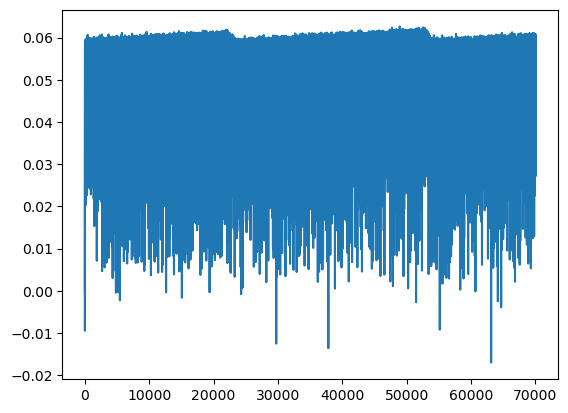

In [ ]:
elapse = ((log.motion['elapsedRealtime'] - log.motion['elapsedRealtime'][0]) / 1e9)
timestamp = (log.motion['timestamp'] - log.motion['timestamp'][0])
(elapse - timestamp).plot()

<Axes: xlabel='datetime'>

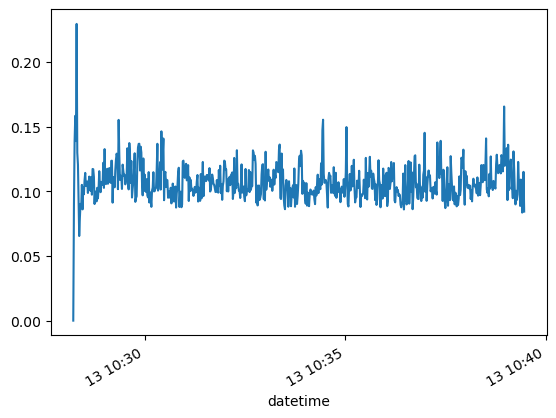

In [ ]:
df_fix = log.fix.loc[log.fix["provider"] == 'GPS']

elapse = (df_fix['elapsedTime'] - df_fix['elapsedTime'][0]) / 1e9
timestamp = (df_fix['unixTime'] - df_fix['unixTime'][0]) / 1e3
(elapse - timestamp).iloc[:].plot()

In [ ]:
# Correct the time values
df_motion = log.motion[['timestamp', 'x', 'y', 'z', 'x_uncal', 'y_uncal', 'z_uncal']].copy()
df_motion['timestamp_corrected'] = df_motion['timestamp']  
df_time = time_df[['system_unix', 'time_correction']]
df_time = df_time.rename(columns={'system_unix': 'timestamp'})

# Ensure timestamps are set as index in both DataFrames
df_motion = df_motion.set_index('timestamp')
df_time = df_time.set_index('timestamp')

# Create a merged dataframe
merged_df = df_motion.merge(df_time, how='outer', left_index=True, right_index=True)

# Interpolate the correction values to all the dataframe
merged_df['time_correction'] = merged_df['time_correction'].interpolate('index')

# Remove first rows because we don't know the clock error yet. Check if too many rows remove (more than 30 seconds)
if(merged_df.index[0] - merged_df.dropna().index[0]) > 30:
    raise Warning("Many row dropped during interpolation.")
merged_df.dropna(inplace=True)

# Apply time correction to timestamps
merged_df['timestamp_corrected'] += merged_df['time_correction']

# Convert to datetime index
index = (merged_df.index*1e9).astype(int)
merged_df.index = pd.to_datetime(index, origin='unix', unit='ns')

merged_df.index

NameError: name 'time_df' is not defined

In [ ]:
import gps_time
import numpy as np
import pandas as pd
from datetime import datetime

# Load log files
folder = "/mnt/c/Users/vmangr/Documents/Datasets/AndroidDevices/dataset_GEOLOC_20240319/dataset/S3/A2"
device = 'GP7'
file = [file for file in os.listdir(f"{folder}/{device}") if "log_mimir" in file][0]

tags = ['Fix', 'GYR_UNCAL', 'Raw']

log = LogReader(manufacturer="", device="", acronym=device, specifiedTags=tags, filepath=f"{folder}/{device}/{file}", mode='old')


df_fix = log.fix.loc[log.fix["provider"] == 'GPS']
df_fix = df_fix[['unixTime', 'elapsedTime', 'elapsedTimeUncertainty']]
df_fix = df_fix.rename(columns={'unixTime': 'timestamp_gps'})
df_fix

,timestamp_gps,elapsedTime,elapsedTimeUncertainty
datetime,,,
2024-03-14 09:47:26.266,1710409646266.000000,154065635305518.000000,200000000.000000
2024-03-14 09:47:27.266,1710409647266.000000,154066628053402.000000,200000000.000000
2024-03-14 09:47:28.259,1710409648259.000000,154067682841773.000000,200000000.000000
2024-03-14 09:47:29.259,1710409649259.000000,154068652262672.000000,200000000.000000
2024-03-14 09:47:30.259,1710409650259.000000,154069657133075.000000,200000000.000000
...,...,...,...
2024-03-14 09:57:37.999,1710410257999.000000,154677312642000.000000,100000.000000
2024-03-14 09:57:38.999,1710410258999.000000,154678312318000.000000,100000.000000
2024-03-14 09:57:39.999,1710410259999.000000,154679312348000.000000,100000.000000


In [ ]:

df = log.raw

# Select only GPS satellites
df = df.drop(df[df['ConstellationType'] != 1].index)

# Select only with suitable TOW
df = df.drop(df[df['State'] & 2^3 == 0].index)

# Only keep the first value of GPS time written (closest to the Unix time)
df = df.drop_duplicates(['TimeNanos'], keep='first')

# Find received time
week = 2305
WEEK_NANOS = 604800000000000
fullbiasnanos = df['FullBiasNanos'][0]
biasnanos = df['BiasNanos'][0]
t_rx_gps = (df['TimeNanos'] - (fullbiasnanos + biasnanos)).to_numpy()
t_rx_gps = t_rx_gps % WEEK_NANOS / 1e9
t_rx_time = [gps_time.GPSTime(week_number=week, time_of_week=time).to_datetime() for time in t_rx_gps]
t_rx_unix = [time.timestamp() for time in t_rx_time]

system_unix = df['timestamp'].to_numpy()
system_time = [datetime.fromtimestamp(time) for time in system_unix]

time_correction = -(system_unix - t_rx_unix + 18 - 2 * 3600) 

time_df = pd.DataFrame({'system_unix': system_unix, 
                        'system_time': system_time,
                        'gps_unix': t_rx_unix, 
                        'gps_time': t_rx_time,
                        'time_correction': time_correction,
                        'elapsedTime': df['ChipsetElapsedRealtimeNanos']})
df_fix
#time_df['time_correction'].plot()

In [ ]:
df_fix.reset_index().iloc[10:30]

,datetime,timestamp_gps,elapsedTime
10,2024-03-14 09:47:21,1710409641000.000000,171960689837940.000000
11,2024-03-14 09:47:22,1710409642000.000000,171961693083502.000000
12,2024-03-14 09:47:23,1710409643000.000000,171962692677179.000000
13,2024-03-14 09:47:24,1710409644000.000000,171963675651008.000000
14,2024-03-14 09:47:25,1710409645000.000000,171964684347455.000000
15,2024-03-14 09:47:26,1710409646000.000000,171965699268403.000000
16,2024-03-14 09:47:27,1710409647000.000000,171966687100079.000000
17,2024-03-14 09:47:28,1710409648000.000000,171967693623141.000000
18,2024-03-14 09:47:29,1710409649000.000000,171968692102972.000000
19,2024-03-14 09:47:30,1710409650000.000000,171969695449841.000000


In [ ]:
df_fix = log.fix.loc[log.fix["provider"] == 'GPS']

#time_df = time_df.set_index('system_time')

df['unixTime']# - time_df['gps_unix']

KeyError: 'unixTime'

<Axes: >

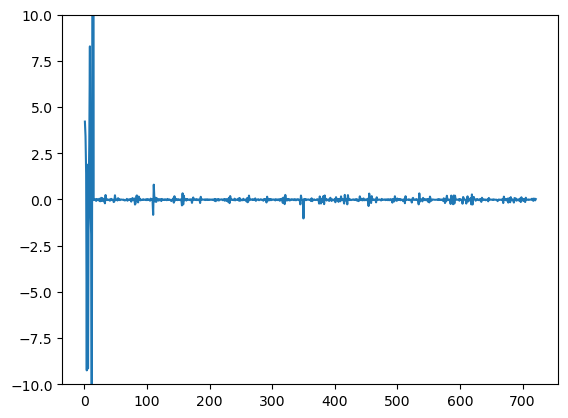

In [ ]:
df = log.fix[log.fix["provider"] == 'GPS']
df = df.reset_index()
unixtime = df['unixTime'].diff()
elapsedTime = df['elapsedTime'].diff()/1e6
(unixtime  - elapsedTime).plot(ylim=(-10, 10))

KeyError: 'ChipsetElapsedRealtimeNanos'

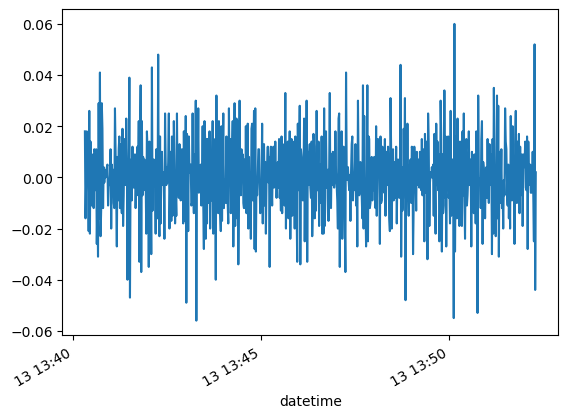

In [ ]:
df = log.raw

# Keep only one GNSS time 
df = df.drop_duplicates(['TimeNanos'], keep='first')

# Removes rows with GNSS bias clock error
df = df.drop(df[df['BiasUncertaintyNanos'] > 100].index)

unixtime = df['timestamp'].diff() - 1
unixtime.plot()

chispsetTime = df['ChipsetElapsedRealtimeNanos'].diff() / 1e9 - 1
chispsetTime.plot() 

timeNanos = df['TimeNanos'] - (df['FullBiasNanos'] + df['BiasNanos'])
timeNanos = timeNanos.diff()/1e9 - 1
timeNanos.plot(ylim=(-0.25, 0.25))